# 과적합 해결

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### 배치 정규화 적용

In [2]:
# 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

100.0%
100.0%
100.0%
100.0%


In [ ]:
# 학습셋-검증셋 사이즈 지정
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# 데이터 분리 및 미니 배치로 로드 가능하도록 DataLoader 생성
train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [ ]:
# 배치 정규화 반영된 간단한 신경망
class SimpleNN(nn.Module):
    def __init__(self, use_bn=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)   # (배치 크기, h, w) -> (배치 크기, feature)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [10]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        print(f'Epoch {epoch + 1} | Val Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_data):.4f}')

In [11]:
print("배치 정규화 적용 안함")
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print()
print("배치 정규화 적용")
model_with_bn = SimpleNN(use_bn=True)
train(model_with_bn, train_loader, val_loader)

배치 정규화 적용 안함
Epoch 1 | Val Loss: 0.2675, Accuracy: 0.9207
Epoch 2 | Val Loss: 0.1935, Accuracy: 0.9427
Epoch 3 | Val Loss: 0.1550, Accuracy: 0.9527
Epoch 4 | Val Loss: 0.1300, Accuracy: 0.9608
Epoch 5 | Val Loss: 0.1288, Accuracy: 0.9617

배치 정규화 적용
Epoch 1 | Val Loss: 0.1288, Accuracy: 0.9628
Epoch 2 | Val Loss: 0.0938, Accuracy: 0.9715
Epoch 3 | Val Loss: 0.0836, Accuracy: 0.9742
Epoch 4 | Val Loss: 0.0766, Accuracy: 0.9756
Epoch 5 | Val Loss: 0.0905, Accuracy: 0.9728


- 배치 사이즈별 모델 학습 결과

In [ ]:
for batch_size in [16, 32, 128]:
    print(f"batch size: {batch_size}")
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

batch size: 16
Epoch 1 | Val Loss: 0.1188, Accuracy: 0.9664
Epoch 2 | Val Loss: 0.0973, Accuracy: 0.9698
Epoch 3 | Val Loss: 0.0940, Accuracy: 0.9708
Epoch 4 | Val Loss: 0.0818, Accuracy: 0.9732
Epoch 5 | Val Loss: 0.0783, Accuracy: 0.9762
batch size: 32
Epoch 1 | Val Loss: 0.1221, Accuracy: 0.9609
Epoch 2 | Val Loss: 0.0917, Accuracy: 0.9719
Epoch 3 | Val Loss: 0.0862, Accuracy: 0.9733
Epoch 4 | Val Loss: 0.0746, Accuracy: 0.9776
Epoch 5 | Val Loss: 0.0796, Accuracy: 0.9764
batch size: 128
Epoch 1 | Val Loss: 0.1576, Accuracy: 0.9529
Epoch 2 | Val Loss: 0.1342, Accuracy: 0.9583
Epoch 3 | Val Loss: 0.0886, Accuracy: 0.9720
Epoch 4 | Val Loss: 0.1013, Accuracy: 0.9694
Epoch 5 | Val Loss: 0.0835, Accuracy: 0.9746


### 드롭아웃 적용

In [ ]:
# 드롭아웃 반영된 간단한 신경망
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# 드롭아웃 비율에 따른 성능 변화
for rate in [0.2, 0.5, 0.8]:
    print(f"Dropout Rate: {rate}")
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

Dropout Rate: 0.2
Epoch 1 | Val Loss: 0.2675, Accuracy: 0.9137
Epoch 2 | Val Loss: 0.1761, Accuracy: 0.9449
Epoch 3 | Val Loss: 0.1507, Accuracy: 0.9557
Epoch 4 | Val Loss: 0.1399, Accuracy: 0.9567
Epoch 5 | Val Loss: 0.1213, Accuracy: 0.9637
Dropout Rate: 0.5
Epoch 1 | Val Loss: 0.3316, Accuracy: 0.9009
Epoch 2 | Val Loss: 0.2738, Accuracy: 0.9192
Epoch 3 | Val Loss: 0.2440, Accuracy: 0.9271
Epoch 4 | Val Loss: 0.2285, Accuracy: 0.9313
Epoch 5 | Val Loss: 0.2369, Accuracy: 0.9284
Dropout Rate: 0.8
Epoch 1 | Val Loss: 1.5781, Accuracy: 0.6101
Epoch 2 | Val Loss: 1.4796, Accuracy: 0.6312
Epoch 3 | Val Loss: 1.4134, Accuracy: 0.5562
Epoch 4 | Val Loss: 1.2935, Accuracy: 0.6082
Epoch 5 | Val Loss: 1.4991, Accuracy: 0.5650


In [15]:
model = DropoutNN(dropout_rate=0.2)

In [ ]:
# 드롭아웃은 학습 시에만 적용됨
model.eval()
with torch.no_grad():
    images, _ = next(iter(val_loader))
    images = images.view(images.size(0), -1)

    out1 = model(images)
    out2 = model(images)

    print(torch.allclose(out1, out2))
    # 드롭아웃이 적용되지 않으므로 매번 같은 출력을 냄

True


In [ ]:
model.train()

out1 = model(images)
out2 = model(images)

print(torch.allclose(out1, out2))
# 드롭아웃이 적용되어 랜덤하게 뉴런이 비활성화되므로 다른 출력을 냄

False


### Learning Rate Scheduler 적용

In [18]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()

        # 학습율 스케쥴러 적용
        scheduler.step()
        print(f'Epoch {epoch + 1} | Val Loss: {val_loss / len(val_loader):.4f}, Accuracy: {correct / len(val_data):.4f}')

In [ ]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)    # 3번의 에폭마다 0.1배씩 학습율 변화

train_lr(model, train_loader, val_loader, optimizer, scheduler)

Epoch 1 | Val Loss: 0.2718, Accuracy: 0.9181
Epoch 2 | Val Loss: 0.2454, Accuracy: 0.9324
Epoch 3 | Val Loss: 0.2448, Accuracy: 0.9282
Epoch 4 | Val Loss: 0.1630, Accuracy: 0.9510
Epoch 5 | Val Loss: 0.1603, Accuracy: 0.9510
Epoch 6 | Val Loss: 0.1488, Accuracy: 0.9557
Epoch 7 | Val Loss: 0.1442, Accuracy: 0.9577
Epoch 8 | Val Loss: 0.1436, Accuracy: 0.9572
Epoch 9 | Val Loss: 0.1432, Accuracy: 0.9578
Epoch 10 | Val Loss: 0.1426, Accuracy: 0.9579


### 조기 종료

In [ ]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        # 조기 종료 반영
        if early_stopping and early_stopping(val_loss):
            print(f'조기 종료 epoch {epoch + 1}')
            break

    return train_losses, val_losses    

In [ ]:
# 조기 종료를 위한 클래스(객체)
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience

In [ ]:
print("Early Stopping 적용 안함")
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, optim_no_es)

print()
print("Early Stopping 적용")
model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, optim_es, early_stopping=early_stopping)

Epoch 1 | Val Loss: 0.2970, Accuracy: 0.9111
Epoch 2 | Val Loss: 0.2585, Accuracy: 0.9270
Epoch 3 | Val Loss: 0.2730, Accuracy: 0.9233
Epoch 4 | Val Loss: 0.2521, Accuracy: 0.9341
Epoch 5 | Val Loss: 0.2165, Accuracy: 0.9390
Epoch 6 | Val Loss: 0.2494, Accuracy: 0.9332
Epoch 7 | Val Loss: 0.2017, Accuracy: 0.9473
Epoch 8 | Val Loss: 0.2798, Accuracy: 0.9263
Epoch 9 | Val Loss: 0.2022, Accuracy: 0.9500
Epoch 10 | Val Loss: 0.2164, Accuracy: 0.9433
Epoch 11 | Val Loss: 0.2113, Accuracy: 0.9493
Epoch 12 | Val Loss: 0.2153, Accuracy: 0.9514
Epoch 13 | Val Loss: 0.1871, Accuracy: 0.9566
Epoch 14 | Val Loss: 0.2103, Accuracy: 0.9529
Epoch 15 | Val Loss: 0.1907, Accuracy: 0.9527
Epoch 16 | Val Loss: 0.2420, Accuracy: 0.9461
Epoch 17 | Val Loss: 0.1846, Accuracy: 0.9533
Epoch 18 | Val Loss: 0.1722, Accuracy: 0.9598
Epoch 19 | Val Loss: 0.2070, Accuracy: 0.9548
Epoch 20 | Val Loss: 0.2276, Accuracy: 0.9521
Epoch 21 | Val Loss: 0.2446, Accuracy: 0.9476
Epoch 22 | Val Loss: 0.2194, Accuracy: 0.95

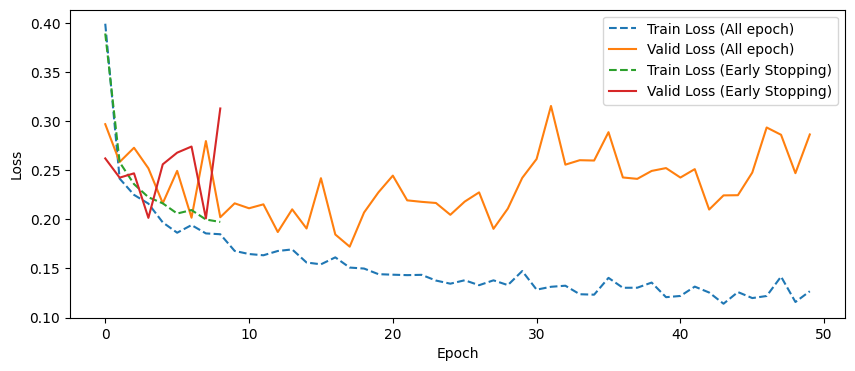

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss (All epoch)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (All epoch)')
plt.plot(train_es_losses, label='Train Loss (Early Stopping)', linestyle='dashed')
plt.plot(val_es_losses, label='Valid Loss (Early Stopping)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### L2 적용

In [26]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    weight_norms = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch + 1} | Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        weight_norm = sum(torch.norm(p).item() for p in model.parameters())
        weight_norms.append(weight_norm)

    return train_losses, val_losses, weight_norms

In [ ]:
print("L2 정규화 적용 안함")
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0.0, momentum=0.9)
train_losses, val_losses, weight_norms = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

print()
print("L2 정규화 적용")
model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)
train_reg_losses, val_reg_losses, weight_norms_reg = train_reg(model_reg, train_loader, val_loader, optim_reg)

Epoch 1 | Val Loss: 0.2547, Accuracy: 0.9191
Epoch 2 | Val Loss: 0.1778, Accuracy: 0.9454
Epoch 3 | Val Loss: 0.1385, Accuracy: 0.9565
Epoch 4 | Val Loss: 0.1420, Accuracy: 0.9566
Epoch 5 | Val Loss: 0.1065, Accuracy: 0.9673
Epoch 6 | Val Loss: 0.1057, Accuracy: 0.9680
Epoch 7 | Val Loss: 0.1131, Accuracy: 0.9673
Epoch 8 | Val Loss: 0.1178, Accuracy: 0.9631
Epoch 9 | Val Loss: 0.1006, Accuracy: 0.9692
Epoch 10 | Val Loss: 0.1005, Accuracy: 0.9704
Epoch 1 | Val Loss: 0.2998, Accuracy: 0.9143
Epoch 2 | Val Loss: 0.2530, Accuracy: 0.9237
Epoch 3 | Val Loss: 0.2413, Accuracy: 0.9314
Epoch 4 | Val Loss: 0.2121, Accuracy: 0.9389
Epoch 5 | Val Loss: 0.2016, Accuracy: 0.9434
Epoch 6 | Val Loss: 0.2076, Accuracy: 0.9451
Epoch 7 | Val Loss: 0.2037, Accuracy: 0.9473
Epoch 8 | Val Loss: 0.2115, Accuracy: 0.9411
Epoch 9 | Val Loss: 0.1897, Accuracy: 0.9476
Epoch 10 | Val Loss: 0.1846, Accuracy: 0.9500


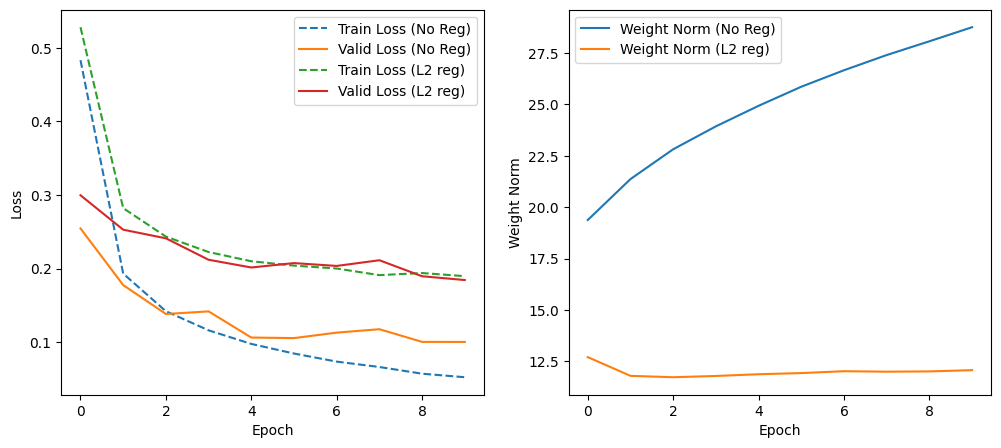

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss (No Reg)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (No Reg)')
plt.plot(train_reg_losses, label='Train Loss (L2 reg)', linestyle='dashed')
plt.plot(val_reg_losses, label='Valid Loss (L2 reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(weight_norms, label='Weight Norm (No Reg)')
plt.plot(weight_norms_reg, label='Weight Norm (L2 reg)')
plt.xlabel('Epoch')
plt.ylabel('Weight Norm')
plt.legend()

plt.show()